# Storing notes in Elasticsearch using Eland

In [1]:
import orgparse
from pydantic import BaseModel
from typing import List
import pandas as pd
import glob 
import logging
from pathlib import Path
import stop_words
import matplotlib.pyplot as plt



In [2]:


import eland as ed
import elasticsearch
import warnings
from elasticsearch.exceptions import ElasticsearchWarning
warnings.simplefilter('ignore', ElasticsearchWarning)

In [5]:
org_df = pd.read_json("../output/roam_df.json", lines=True, orient="records")

## Org node elements

OrgElement represents an org-mode subheading.

In [2]:
from pydantic import BaseModel
import re

class OrgElement(BaseModel):
    org_id: str
    file_name: str
    heading: str
    level: int
    body: str
    links: List[str]
    text: str

    @classmethod
    def get_org_node_elements(cls, file_name, file_node, full_root_contents=False):
        root_element = cls._get_root_node_element(file_node, file_name)
        children_elements = [
            cls._get_child_node_element(root_element, child_node)
            for child_node in file_node[1:]
        ]
        return [root_element] + children_elements

    @classmethod
    def _get_root_node_element(cls, file_node, file_name=None, full_root_contents=False):
        org_id = file_node.properties["ID"]
        if file_name is None:
            file_name = file_node.body.replace("#+title: ", "").strip()
        all_links = [link for child_node in file_node[1:] for link in cls.parse_links(str(child_node))]
        return OrgElement(
            org_id=org_id,
            file_name=file_name,
            heading=file_node.heading,
            level=file_node.level,
            body=file_node.body,
            links=all_links,
            text=cls._get_root_contents(file_node, full_root_contents)
        )

    @classmethod
    def _get_root_contents(cls, file_node, full_root_contents):
        if full_root_contents:
            text = "\n\n".join(str(elem) for elem in file_node)
        else:
            return file_node.heading + "\n" + file_node.body
    
    @classmethod
    def _get_child_node_element(cls, root_element, child_node):
        return OrgElement(
            org_id=root_element.org_id,
            file_name=root_element.file_name,
            heading=child_node.heading,
            level=child_node.level,
            body=child_node.body,
            links=cls.parse_links(str(child_node)),
            text=child_node.heading + "\n" + child_node.body
        )
        
    @classmethod
    def parse_links(cls, content):
        return re.findall(r'(?<=\[\[id:)([a-zA-Z0-9\-]+)(?=\]\[)', content)


    @classmethod
    def load(cls, org_path):
        file_name = Path(org_path).stem
        return cls.get_org_node_elements(file_name, orgparse.load(org_path))

    @classmethod
    def load_dir_generator(cls, dir):
        dir_p = Path(dir) / "**" / "*.org"
        for org_file_path in glob.glob(str(dir_p)):
            try:
                elems = cls.load(org_file_path)
            except Exception as e:
                logging.warn(f"cannot parse {org_file_path} elements")
                logging.warn(str(e))
                continue
            else:
                for elem in elems:
                    yield elem
    
    @classmethod
    def to_df(cls, org_elements):
        return pd.DataFrame.from_records([elem.dict() for elem in org_elements])

In [3]:
## TESTS

str_link = "[[id:6a7500f7-931d-4478-b046-9cadf5f78755][pragmatics_context]]"
assert len(OrgElement.parse_links(str_link)) == 1

example_file_path = Path("/home/kuba/Projects/org/roam/20230608134327-pragmatics.org").expanduser()
assert len(OrgElement.load(example_file_path)) == 11

In [4]:
OrgElement.load(example_file_path)

[OrgElement(org_id='78523f9b-b835-4f3e-be95-96671a599479', file_name='20230608134327-pragmatics', heading='', level=0, body='#+title: pragmatics\n\n', links=['6a7500f7-931d-4478-b046-9cadf5f78755', '6a027580-d5c7-4f9d-95b1-0b2a93d2a27f'], text='\n#+title: pragmatics\n\n'),
 OrgElement(org_id='78523f9b-b835-4f3e-be95-96671a599479', file_name='20230608134327-pragmatics', heading='Sources', level=1, body='\nYasutada Sudo - Experimental approaches to scalar implicatures (under teaching)\n', links=[], text='Sources\n\nYasutada Sudo - Experimental approaches to scalar implicatures (under teaching)\n'),
 OrgElement(org_id='78523f9b-b835-4f3e-be95-96671a599479', file_name='20230608134327-pragmatics', heading='Intro', level=1, body='', links=[], text='Intro\n'),
 OrgElement(org_id='78523f9b-b835-4f3e-be95-96671a599479', file_name='20230608134327-pragmatics', heading='Pragmatics', level=2, body='\nPragmatics explores *meaning in context*.\nMeaning not relative to context, so called *truth-value 

In [5]:
elem_generator = OrgElement.load_dir_generator("/home/kuba/Projects/org")

In [6]:
roam_df = OrgElement.to_df(elem_generator)

/tmp/ipykernel_952379/3393138106.py:74: DeprecationWarning: The 'warn' function is deprecated, use 'warning' instead
  logging.warn(f"cannot parse {org_file_path} elements")
/tmp/ipykernel_952379/3393138106.py:75: DeprecationWarning: The 'warn' function is deprecated, use 'warning' instead
  logging.warn(str(e))
/tmp/ipykernel_952379/3393138106.py:83: PydanticDeprecatedSince20: The `dict` method is deprecated; use `model_dump` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.5/migration/
  return pd.DataFrame.from_records([elem.dict() for elem in org_elements])


In [7]:
es_client = elasticsearch.Elasticsearch([{'host': 'localhost', 'port': 9200, 'scheme':'http'}])

In [8]:
existing_behavior = "replace"

roam_elastic_df = ed.pandas_to_eland(
    roam_df,
    es_client=es_client,
    es_dest_index="org_roam",
    es_type_overrides={"text": "text"},
    es_if_exists=existing_behavior
)

/home/kuba/.cache/pypoetry/virtualenvs/noteboard-pn0B81or-py3.10/lib/python3.10/site-packages/eland/field_mappings.py:951: UserWarning: Eland major version (8.11.1) doesn't match the major version of the Elasticsearch server (7.17.16) which can lead to compatibility issues. Your Eland major version should be the same as your cluster major version.
  elastic_version = es_version(client)


In [9]:
type(roam_elastic_df)

eland.dataframe.DataFrame

In [10]:
roam_elastic_df.es_match("pragmatics", columns="text")

,body,file_name,heading,level,links,org_id,text


## Topic modeling

In [11]:
texts = roam_elastic_df["text"].to_pandas().values

In [12]:
from sklearn import decomposition, feature_extraction, pipeline

n_topics = 25
lda = decomposition.LatentDirichletAllocation(n_components=n_topics, random_state=0)

lda_pipeline = pipeline.make_pipeline(
    feature_extraction.text.CountVectorizer(),
    lda
)

In [13]:
type(lda_pipeline)

sklearn.pipeline.Pipeline

In [327]:
from pydantic import BaseModel, Field
from typing import Callable

class TopicModeler(BaseModel):
    tm_pipeline: pipeline.Pipeline
    text_col: str
    preprocess_texts: Callable[pd.Series, pd.Series]

    @classmethod
    def init_unfitted(cls, make_vectorizer, make_topic_modeler, n_topics, text_col, vectorizer_kwargs, tm_kwargs, preprocess_texts):
        tm_kwargs["n_components"] = n_topics
        tm_pipeline = pipeline.make_pipeline(make_vectorizer(**vectorizer_kwargs), make_topic_modeler(**tm_kwargs))
        return TopicModeler(tm_pipeline=tm_pipeline, text_col=text_col, preprocess_texts=preprocess_texts)

    @classmethod
    def init(cls, texts_df, make_vectorizer, make_topic_modeler, n_topics, text_col="text", vectorizer_kwargs={}, tm_kwargs={}, preprocess_texts=lambda texts: texts):
        tm = cls.init_unfitted(make_vectorizer, make_topic_modeler, n_topics, text_col, vectorizer_kwargs, tm_kwargs, preprocess_texts)
        tm.tm_pipeline.fit(preprocess_texts(texts_df[text_col]))
        return tm
    
    def get_topic_representatives(self, texts_df, topic_idx, agg_by=None, topk=5):
        topic_scores = self.tm_pipeline.transform(texts_df[self.text_col])[:,topic_idx]
        top_idxs = topic_scores.argsort()[::-1][:topk]
        results_df = texts_df.iloc[top_idxs]
        return results_df.assign(topic_score=topic_scores[top_idxs])

    def get_top_topic_words(self, topk=25):
        return self.features[self.topic_loadings.argsort(axis=1)[:,::-1][:,:topk]]

    def get_topics(self, texts_df):
        preprocessed_texts = self.preprocess_texts(texts_df[self.text_col])
        return pd.Series(self.tm_pipeline.transform(preprocessed_texts).argmax(axis=1))
    
    @property
    def features(self):
        (_, vectorizer) = self.tm_pipeline.steps[0]
        return vectorizer.get_feature_names_out()

    @property
    def topic_loadings(self):
        (_, tm) = self.tm_pipeline.steps[-1]
        return tm.components_
        
    @property
    def n_features(self):
        return len(self.features)

    @property
    def n_topics(self):
        [(_, tm)] = self.tm_pipeline.steps[-1:]
        return tm.n_components
    
    class Config:
        arbitrary_types_allowed = True

In [328]:
org_file_contents = roam_df.groupby("file_name").apply(lambda df: "\n".join(df["text"]))
org_file_roam_df = pd.DataFrame(org_file_contents)
org_file_roam_df.columns = ["text"]
org_file_roam_df = org_file_roam_df.reset_index()

In [460]:
n_topics = 25

used_stop_words = stop_words.get_stop_words("en") + stop_words.get_stop_words("pl")
vectorizer_kwargs={"min_df": 5, "binary": True, "stop_words": used_stop_words}
nmf_kwargs = {"alpha_W": 1e-4, "l1_ratio": 0.0, "beta_loss": "kullback-leibler"}


def preprocess_snakecase(texts):
    return texts.str.replace("_", " ").str.replace(r" \d+ |\d{3,}", " NUMBER ")


lda_tm = TopicModeler.init(
    org_file_roam_df,
    n_topics=n_topics,
    make_vectorizer=feature_extraction.text.CountVectorizer,
    make_topic_modeler=decomposition.LatentDirichletAllocation,
    vectorizer_kwargs=vectorizer_kwargs,
    preprocess_texts=preprocess_snakecase
)

nmf_tm = TopicModeler.init(
    org_file_roam_df,
    n_topics=n_topics,
    make_vectorizer=feature_extraction.text.TfidfVectorizer,
    vectorizer_kwargs=vectorizer_kwargs,
    make_topic_modeler=decomposition.NMF,
    preprocess_texts=preprocess_snakecase
)


In [461]:
lda_tm.get_topics(roam_df).value_counts()

18    475
0     469
22    365
17    362
21    359
13    357
5     346
12    274
24    255
23    240
3     211
11    197
8     180
10    157
20    156
7     145
19    133
14    118
6     115
1     105
15     93
2      89
9      71
16     68
4      41
dtype: int64

In [462]:
nmf_tm.get_topics(roam_df).value_counts()

4     825
0     575
2     434
17    354
19    258
1     255
18    239
21    209
15    187
24    184
10    171
14    167
3     160
16    151
8     146
5     145
13    140
22    135
23    120
6     111
12    101
7     101
20     86
11     81
9      46
dtype: int64

## Guessing good parameters for NMF

We optimize for the smallest size of biggest cluster

In [444]:
import optuna

def objective(trial):
    
    nmf_kwargs = {
        "alpha_W": trial.suggest_loguniform("alpha_W", 1e-6, 0.1),
        "beta_loss": trial.suggest_categorical("beta_loss", ["frobenius", "kullback-leibler"]),
        "solver": "mu"
    }
    
    nmf_tm = TopicModeler.init(
        org_file_roam_df,
        n_topics=n_topics,
        make_vectorizer=feature_extraction.text.TfidfVectorizer,
        vectorizer_kwargs=vectorizer_kwargs,
        make_topic_modeler=decomposition.NMF,
        tm_kwargs=nmf_kwargs,
        preprocess_texts=preprocess_snakecase
    )
    return nmf_tm.get_topics(roam_df).value_counts().max()
    

In [445]:
study = optuna.create_study()
study.optimize(objective, n_trials=100, n_jobs=8)

[I 2023-12-27 23:45:56,386] A new study created in memory with name: no-name-b0471dbf-30a9-4f33-a916-7ad869f4777e
[I 2023-12-27 23:45:59,125] Trial 0 finished with value: 3529.0 and parameters: {'alpha_W': 0.001904055257294491, 'beta_loss': 'frobenius'}. Best is trial 0 with value: 3529.0.
[I 2023-12-27 23:46:00,657] Trial 8 finished with value: 797.0 and parameters: {'alpha_W': 5.833160457840984e-05, 'beta_loss': 'frobenius'}. Best is trial 8 with value: 797.0.
[I 2023-12-27 23:46:05,853] Trial 4 finished with value: 783.0 and parameters: {'alpha_W': 8.923366478586338e-05, 'beta_loss': 'kullback-leibler'}. Best is trial 4 with value: 783.0.
[I 2023-12-27 23:46:06,601] Trial 1 finished with value: 798.0 and parameters: {'alpha_W': 0.00046426298609187743, 'beta_loss': 'kullback-leibler'}. Best is trial 4 with value: 783.0.
[I 2023-12-27 23:46:06,788] Trial 5 finished with value: 796.0 and parameters: {'alpha_W': 5.6329037183634475e-06, 'beta_loss': 'kullback-leibler'}. Best is trial 4 w

In [447]:
trials_df = pd.DataFrame.from_records([{**trial.params, "value": trial.value} for trial in study.get_trials()])

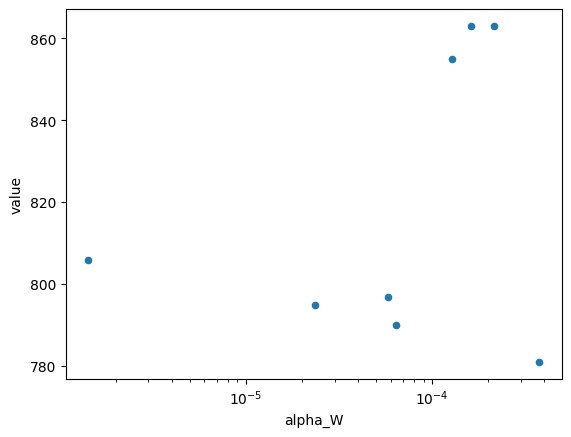

In [459]:
trials_df[(trials_df["value"] < 1000) & (trials_df["beta_loss"] == "frobenius")].plot.scatter("alpha_W", "value")
plt.xscale("log")

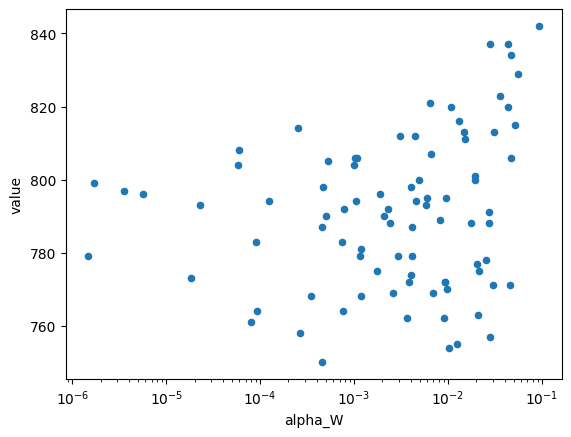

In [458]:
trials_df[(trials_df["value"] < 1000) & (trials_df["beta_loss"] == "kullback-leibler")].plot.scatter("alpha_W", "value")
plt.xscale("log")

In [463]:
trials_df.groupby("beta_loss").agg({"value": "mean"})

,value
beta_loss,
frobenius,2641.714286
kullback-leibler,790.779070


In [306]:
nmf_tm.tm_pipeline.transform(roam_df["text"]).argmax(axis=1)

array([ 8, 14,  2, ...,  6,  6,  6])

# Topic representatives

In [464]:
lda_tm.get_topic_representatives(roam_df, 23, topk=100).groupby(["file_name"]).agg({"topic_score": "mean"}).sort_values("topic_score", ascending=False).iloc[:25]

,topic_score
file_name,
20230330214814-python_async_batch_runner,0.993846
20230404102213-chatgpt_conversations_apis,0.989091
20230607161855-rust,0.961600
20230912231001-elixir_ash,0.954813
20230628104848-pydantic,0.954286
20230707222157-elixir_protocols,0.943529
20230523094954-llms_utils,0.919005
20230422190758-inbox,0.907438
20230707213612-fibs,0.837198


In [465]:
nmf_tm.get_topic_representatives(roam_df, 1, topk=100).groupby(["file_name"]).agg({"topic_score": "mean"}).sort_values("topic_score", ascending=False).iloc[:25]

,topic_score
file_name,
20230227112833-polish_ner,0.513908
20231013220800-notes_simplicity,0.513908
20231027151103-manifold_examples,0.513908
20231026161307-computer_vision,0.513908
20231026160454-hobbies,0.513908
20231024195119-second_brain_map,0.513908
20231020131659-ultraproducts,0.513908
20231018232121-tomato_tda,0.513908
20231018231922-tda_carlsson,0.513908


## Top words per topic

In [466]:
nmf_tm.get_top_topic_words()[:,:5]

array([['file', 'name', 'api', 'write', 'code'],
       ['title', 'software', 'categories', 'stuff', 'hardware'],
       ['like', 'also', 'logic', 'used', 'example'],
       ['llms', 'llm', 'huggingface', 'llama', 'models'],
       ['można', 'które', 'będzie', 'trzeba', 'np'],
       ['exports', 'session', 'src', 'begin', 'end'],
       ['mgr', 'nbow', 'data', 'title', 'generated'],
       ['ml', 'general', 'title', 'drift', 'learning'],
       ['https', 'com', 'github', 'www', 'pdf'],
       ['philosophy', 'science', 'analytic', 'phase', 'logic'],
       ['projects', 'home', 'kuba', 'org', 'roam'],
       ['nlp', 'polish', 'transformers', 'general', 'summarization'],
       ['tools', 'python', 'toolz', 'videos', 'neo4j'],
       ['manifold', 'julia', 'tda', 'learning', 'manifolds'],
       ['elixir', 'rust', 'software', 'programming', 'languages'],
       ['tl', 'dr', 'like', 'toolkit', 'papers'],
       ['work', 'rejestracje', 'medsi', 'serwisy', 'ai'],
       ['generation', 'models'

In [468]:
lda_tm.get_top_topic_words()[:,:5]

array([['title', 'llms', 'run', 'token', 'model'],
       ['title', 'principle', 'mgr', 'principles', 'livebook'],
       ['note', 'complex', 'write', 'another', 'creating'],
       ['title', '13', '10', '12', '14'],
       ['title', 'begin', 'end', 'number', 'org'],
       ['title', 'llms', 'nlp', 'qa', 'models'],
       ['title', 'models', 'can', 'like', 'ml'],
       ['language', 'number', 'different', 'pragmatics', 'models'],
       ['title', 'sum', 'basic', 'like', 'also'],
       ['title', 'like', 'use', 'gpt', 'stuff'],
       ['title', 'generation', 'information', 'manifold', 'mgr'],
       ['title', 'ml', 'general', 'nlp', 'pipeline'],
       ['use', 'can', 'will', 'make', 'run'],
       ['title', 'begin', 'end', 'model', 'number'],
       ['title', 'mgr', 'data', 'number', 'https'],
       ['title', 'hardware', 'vs', 'features', 'can'],
       ['title', 'theory', 'like', 'trick', 'optimization'],
       ['title', 'cite', 'space', 'number', 'geometry'],
       ['które', 'wm', 

## BERTopic

small - runs on org nodes
big - runs on whole files

In [78]:
import bertopic

/home/kuba/.cache/pypoetry/virtualenvs/noteboard-pn0B81or-py3.10/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [178]:
mmr_topic_representation_model = bertopic.representation.MaximalMarginalRelevance(diversity=0.3)
keybert_topic_representation_model = bertopic.representation.KeyBERTInspired()

bertopic_models = {}
bertopic_models["big_kw"] = bertopic.BERTopic(language="multilingual", representation_model=keybert_topic_representation_model, nr_topics=50, min_topic_size=5)
bertopic_models["big_mmr"] = bertopic.BERTopic(language="multilingual", representation_model=mmr_topic_representation_model, nr_topics=50, min_topic_size=5)
bertopic_models["small_kw"] = bertopic.BERTopic(language="multilingual", representation_model=keybert_topic_representation_model, nr_topics=50, min_topic_size=25)
bertopic_models["small_mmr"] = bertopic.BERTopic(language="multilingual", representation_model=mmr_topic_representation_model, nr_topics=50, min_topic_size=25)

In [180]:
def show_bertopic(bertopic_model):
    for topic in sorted(bertopic_model.topic_sizes_.keys()):
        print(f"topic {topic}")
        topic_info = bertopic_model.get_topic_info(topic).iloc[0]
        print(f"number of documents {topic_info['Count']}")
        if topic_info["Count"] > 0:
            print(topic_info["Representation"])
        print()

## BERTopic

Seems like the cluster merging results in high imbalance

In [470]:
#bertopic_models["big_kw"].fit(org_file_contents)
#bertopic_models["big_mmr"].fit(org_file_contents.values)

In [471]:
bertopic_models["small_kw"].fit(preprocess_snakecase(roam_df["text"]).values)
bertopic_models["small_mmr"].fit(preprocess_snakecase(roam_df["text"]).values)

In [472]:
show_bertopic(bertopic_models["small_kw"])

topic -1
number of documents 1811
['youtube', 'url', 'json', 'org', 'code', 'add', 'user', 'import', 'export', 'using']

topic 0
number of documents 42
['methods', 'method', 'techniques', 'approach', 'approaches', 'how', 'algorithm', 'algorithms', 'funkcje', 'kroki']

topic 1
number of documents 550
['euclidean', 'manifolds', 'manifold', 'geometry', 'topological', 'metric', 'theorem', 'dimensional', 'theory', 'topology']

topic 2
number of documents 28
['cypher', 'database', 'query', 'data', 'allshortestpaths', 'neo4j', 'indexes', 'graph', 'using', 'properties']

topic 3
number of documents 110
['graphml', 'graphs', 'graphio', 'graph', 'simplegraph', 'lightgraphs', 'matplotlib', 'scatterplot', 'plot', 'dataframe']

topic 4
number of documents 55
['pipeline', 'pipelines', 'tail', 'transformerssummarizer', 'recursion', 'cache', 'component', 'beir', 'summary', 'inputs']

topic 5
number of documents 33
['clearml', 'clearmla', 'tag', 'code', 'config', 'dictconfig', 'add', 'pipeline', 'pipel

In [473]:
show_bertopic(bertopic_models["small_mmr"])

topic -1
number of documents 1830
['your', 'with', 'can', 'number', 'title', 'if', 'json', 'data', 'id', 'function']

topic 0
number of documents 42
['methods', 'approaches', 'algorithms', 'algorithm', 'optimization', 'objective', 'modes', 'tier', 'satisfiability', 'computations']

topic 1
number of documents 47
['volatility', 'implied', 'market', 'options', 'disruptive', 'innovation', 'yfinance', 'pricing', 'asset', 'financial']

topic 2
number of documents 32
['clearml', 'host', 'localhost', 'caching', 'docker', 'config', 'parameters', 'echo', 'sysctl', 'pipelines']

topic 3
number of documents 57
['pipeline', 'pipelines', 'ranker', 'optimization', 'caching', 'haystack', 'cache', 'component', 'bm25retriever', 'sentencetransformersranker']

topic 4
number of documents 27
['metrics', 'predicted', 'reference', 'hfmetricsevaluator', 'df', 'evaluator', 'scores', 'github', 'projects', 'dataframe']

topic 5
number of documents 117
['graph', 'graphs', 'edge', 'vertices', 'neo4j', 'visualizat

## Results

Bertopic is too aggressive when it comes to merging clusters.

LDA is least aggressive, but it seems like NMF pipeline is better (likely because it's easy to optimize the hyperparams)

In [479]:
bertopic_models["small_mmr"].topic_sizes_[-1]

1830

In [480]:
bertopic_models["small_kw"].topic_sizes_[-1]

1811

In [484]:
lda_tm.get_topics(roam_df).value_counts().max()

475

In [483]:
nmf_tm.get_topics(roam_df).value_counts().max()

825

NMF results in highly interpretable topics:

- NLP
- general software
- philosophy and logic
- mathematics
- information retrieval

In [486]:
nmf_tm.get_top_topic_words()[:,:5]

array([['file', 'name', 'api', 'write', 'code'],
       ['title', 'software', 'categories', 'stuff', 'hardware'],
       ['like', 'also', 'logic', 'used', 'example'],
       ['llms', 'llm', 'huggingface', 'llama', 'models'],
       ['można', 'które', 'będzie', 'trzeba', 'np'],
       ['exports', 'session', 'src', 'begin', 'end'],
       ['mgr', 'nbow', 'data', 'title', 'generated'],
       ['ml', 'general', 'title', 'drift', 'learning'],
       ['https', 'com', 'github', 'www', 'pdf'],
       ['philosophy', 'science', 'analytic', 'phase', 'logic'],
       ['projects', 'home', 'kuba', 'org', 'roam'],
       ['nlp', 'polish', 'transformers', 'general', 'summarization'],
       ['tools', 'python', 'toolz', 'videos', 'neo4j'],
       ['manifold', 'julia', 'tda', 'learning', 'manifolds'],
       ['elixir', 'rust', 'software', 'programming', 'languages'],
       ['tl', 'dr', 'like', 'toolkit', 'papers'],
       ['work', 'rejestracje', 'medsi', 'serwisy', 'ai'],
       ['generation', 'models'

## Labeling nodes

### TODO Semantic router 

### Zero-shot learning

The following code uses ZSL API 

In [59]:
import requests
from pydantic import BaseModel, Field
import scipy


class ZSLAPIClient(BaseModel):
    url: str = Field(default="http://localhost:8765/zero_shot_classify")

    def predict(self, texts, candidate_labels):
        body = {
            "texts": texts,
            "candidate_labels": candidate_labels
        }
        return requests.post(self.url, json=body).json()

In [35]:
zsl_client = ZSLAPIClient()

In [76]:
labels = [
    "natural language processing",
    "large language models",
    "general machine learning",
    "theoretical mathematics",
    "information retrieval",
    "manifold learning",
    "linguistics",
    "rust",
    "python",
]

In [53]:
zsl_client.predict(["Sentence transformers is a library using transformers to embed text"], classes)

[{'text': 'Sentence transformers is a library using transformers to embed text',
  'label': 'natural language processing',
  'label_scores': {'natural language processing': 0.2332240790128708,
   'information retrieval': 0.20098677277565002,
   'manifold learning': 0.1698964536190033,
   'large language models': 0.11025629937648773,
   'general machine learning': 0.10574998706579208,
   'linguistics': 0.08562103658914566,
   'theoretical mathematics': 0.042149852961301804,
   'rust': 0.030424781143665314,
   'python': 0.021690696477890015}}]

In [140]:
def get_n_lines(t):
    return len(t.strip().split("\n"))

org_contents_df = org_df[org_df["text"].apply(get_n_lines) >= 4]

In [141]:
org_contents_df["text"].apply(lambda t: len(t.strip().split("\n"))).describe()

count    2239.000000
mean       19.218401
std        44.987419
min         4.000000
25%         5.000000
50%         7.000000
75%        14.000000
max      1100.000000
Name: text, dtype: float64

In [142]:
def batched(items, batch_size):
    for i in range(0, len(items), batch_size):
        yield items[i:i + batch_size]

In [143]:
import tqdm

In [144]:
def get_row_topk_entropy(row, k=3):
    return scipy.stats.entropy(row.sort_values(ascending=False)[:k])

def get_topk_entropy(df, cols, k=3):
    score_df = df[cols]
    return score_df.apply(get_row_topk_entropy, axis=1)


def get_predictions_df(texts, candidate_labels,  batch_size=64):
    preds = []
    for b in tqdm.tqdm(list(batched(texts, batch_size))):
        for res in zsl_client.predict(b, candidate_labels):
            label_scores = res.pop("label_scores")
            preds.append({**res, **label_scores})
    return pd.DataFrame.from_records(preds)

def add_topk_entropy(df, candidate_labels, k=3):
    df[f"top_{k}_entropy"] = get_topk_entropy(df, k=k, cols=candidate_labels)
    return df

In [145]:
zsl_predictions_df = add_topk_entropy(get_predictions_df(org_contents_df["text"].to_list(), labels), candidate_labels=labels)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 35/35 [01:09<00:00,  1.99s/it]


In [148]:
zsl_predictions_df.sort_values("top_3_entropy").iloc[:25]

,text,label,entropy,rust,linguistics,natural language processing,python,manifold learning,theoretical mathematics,large language models,information retrieval,general machine learning,top_3_entropy
2029,Flow in Python\n\n1. get requirements\n2. make...,python,0.378908,0.002164,0.004160,0.016345,0.932294,0.009877,0.004823,0.012679,0.009092,0.008567,0.156094
686,Python w org-mode\nob-ipython dodaje ipythona ...,python,0.428016,0.003722,0.006803,0.015040,0.922533,0.010294,0.008058,0.007869,0.014381,0.011299,0.159295
2063,Defining GitHub information retrieval problem\...,information retrieval,0.436278,0.007782,0.007356,0.008601,0.004278,0.019258,0.010184,0.013068,0.920477,0.008996,0.171032
502,Rust ir backend\n\nTantivy looks promising\n\n...,rust,0.426635,0.919070,0.006077,0.007595,0.002396,0.013406,0.005653,0.006356,0.031516,0.007932,0.216783
1650,\n#+title: linguistics\n\n\ngeneral_nlp\n\nhtt...,linguistics,0.648141,0.009414,0.867344,0.023556,0.002421,0.019492,0.009593,0.027793,0.016662,0.023725,0.254692
1799,\n#+title: llms/llama\n\nllama_hardware\n\nhtt...,large language models,0.649758,0.009308,0.032264,0.020405,0.005219,0.017248,0.012939,0.868215,0.018795,0.015606,0.257359
1851,edit distance - python Levenshtein\n- slow\n- ...,python,0.629956,0.004438,0.010551,0.021458,0.872803,0.012618,0.015029,0.013311,0.033343,0.016447,0.263975
1576,\n#+title: rust_elixir\n\nrust\n\nhttps://fly....,rust,0.692885,0.857103,0.012564,0.021956,0.004946,0.030396,0.014760,0.016172,0.027546,0.014556,0.279824
1675,Cool Rust tools\n\n#+BEGIN_SRC bash :session 2...,rust,0.798443,0.827939,0.014241,0.025546,0.005218,0.027703,0.015483,0.019394,0.038790,0.025686,0.315216
540,Language models\n\n/Language models/ are machi...,large language models,0.741160,0.005415,0.028749,0.024085,0.003501,0.035507,0.015125,0.840032,0.013168,0.034418,0.324248


In [151]:
zsl_predictions_df.sort_values("information retrieval", ascending=False)

,text,label,entropy,rust,linguistics,natural language processing,python,manifold learning,theoretical mathematics,large language models,information retrieval,general machine learning,top_3_entropy
2063,Defining GitHub information retrieval problem\...,information retrieval,0.436278,0.007782,0.007356,0.008601,0.004278,0.019258,0.010184,0.013068,0.920477,0.008996,0.171032
20,brt\n\n- information retrieval\n- optionally R...,information retrieval,0.874260,0.065324,0.012457,0.026641,0.005180,0.025587,0.014855,0.012401,0.798346,0.039207,0.435022
663,\n#+title: information_retrieval\n\nnlp/senten...,information retrieval,0.957113,0.009711,0.034735,0.041731,0.008194,0.031190,0.021164,0.027392,0.780007,0.045875,0.397093
1398,Klasyczne wyszukiwanie (na sterydach)\n\nSłowa...,information retrieval,0.972837,0.013325,0.074167,0.043811,0.011163,0.016940,0.023824,0.029859,0.769490,0.017422,0.479626
1718,Retrieval schema\n\nUses\n\nfile:~/Projects/gi...,information retrieval,1.022931,0.010853,0.025268,0.048423,0.009803,0.035098,0.021847,0.043403,0.758961,0.046344,0.425525
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1650,\n#+title: linguistics\n\n\ngeneral_nlp\n\nhtt...,linguistics,0.648141,0.009414,0.867344,0.023556,0.002421,0.019492,0.009593,0.027793,0.016662,0.023725,0.254692
686,Python w org-mode\nob-ipython dodaje ipythona ...,python,0.428016,0.003722,0.006803,0.015040,0.922533,0.010294,0.008058,0.007869,0.014381,0.011299,0.159295
540,Language models\n\n/Language models/ are machi...,large language models,0.741160,0.005415,0.028749,0.024085,0.003501,0.035507,0.015125,0.840032,0.013168,0.034418,0.324248
1733,TL;DR\n\nLoRA: Low-Rank Adaptation of Large La...,large language models,0.688237,0.014350,0.065713,0.013864,0.003233,0.016412,0.015638,0.848847,0.011390,0.010553,0.342512


In [180]:
scored_org_contents_df = org_contents_df.merge(zsl_predictions_df, on="text")

In [182]:
scored_org_contents_df["top_3_entropy"].describe()

count    2267.000000
mean        1.040377
std         0.124063
min         0.156094
25%         1.052866
50%         1.087155
75%         1.096423
max         1.098612
Name: top_3_entropy, dtype: float64

## Results

These results seem OK but  

<Axes: xlabel='modified'>

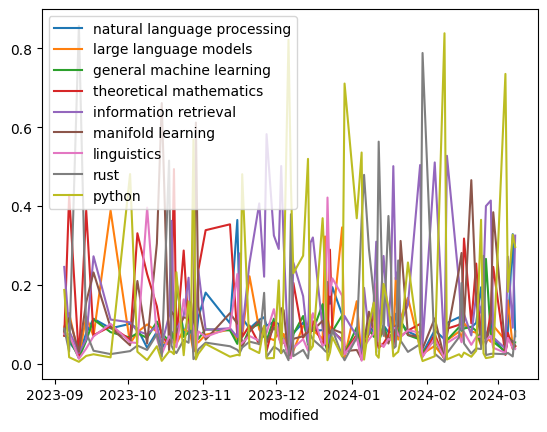

In [183]:
scored_org_contents_df[scored_org_contents_df["top_3_entropy"] < 1][labels].groupby(pd.to_datetime(scored_org_contents_df["modified"]).dt.date).agg("mean").plot()